## Digital Signal Processing - Practical 4:  
### Yanny vs Laurel, which name do you hear? (DFT & Filtering)

<img src="https://i.ytimg.com/vi/yDiXQl7grPQ/maxresdefault.jpg" width="300" height="360" border="1" />

## Part 1 Discrete Fourier Transform
In this notebook we use windowed DFTs to break an audio recording of the popular Yanny-Laurel sound into its time-varying component frequencies and plot a spectrogram.

In [17]:
import numpy as np
import math
from matplotlib import pyplot
from scipy.signal import butter, lfilter
from scipy.io import wavfile
from IPython.display import Audio

%matplotlib inline

### Load the .wav file

In [22]:
sampling_rate, pcm_values = wavfile.read("laurel_yanny.wav")

### Play the orginal audio

In [20]:
Audio(data=pcm_values, rate=sampling_rate)

### Plot the signal

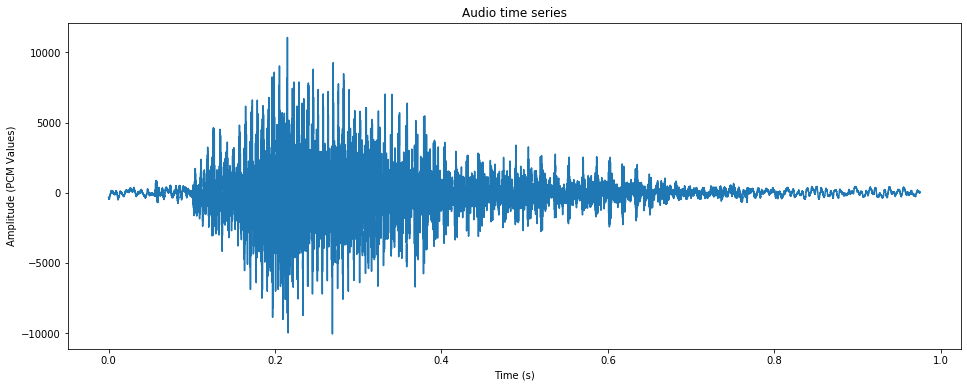

In [47]:
num_samples = len(pcm_values)  # Number of sample points
sample_spacing = 1.0 / sampling_rate  # Sample spacing (i.e. period)
time = np.linspace(start=0, stop=num_samples / sampling_rate, num=len(pcm_values))

pyplot.figure(figsize=(16, 6))
pyplot.title("Audio time series")
pyplot.ylabel("Amplitude (PCM Values)")
pyplot.xlabel("Time (s)")
pyplot.plot(time, pcm_values)

### Apply Discrete Fourier Transform (FFT) on the signal and plot the magnitute of each coefficient of the transform

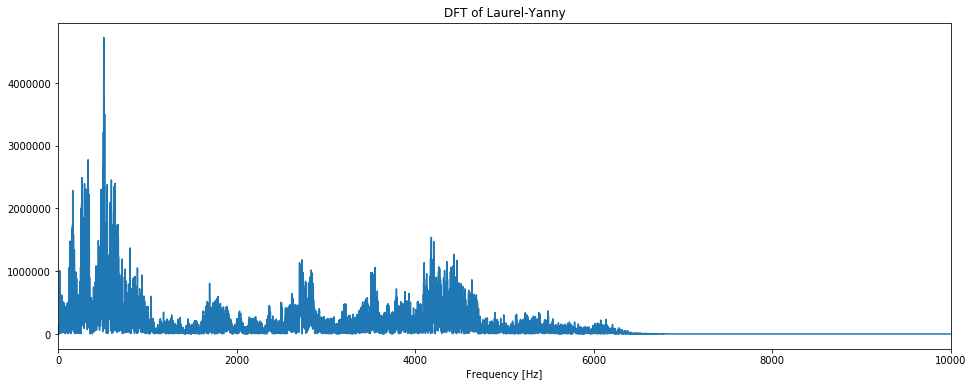

In [48]:
dft_y = np.fft.rfft(pcm_values) # Compute the one-dimensional n-point discrete Fourier Transform (DFT) of a real-valued array by means of the Fast Fourier Transform.
dft_frequencies = np.fft.rfftfreq(num_samples, d=sample_spacing) # Get the frequency bin centers in cycles per unit of the sample spacing (with zero at the start).

pyplot.figure(figsize=(16, 6))
pyplot.title("DFT of %s" % "Laurel-Yanny")
pyplot.ylabel("")
pyplot.xlabel("Frequency [Hz]")
pyplot.xlim(0, 10000)
pyplot.plot(dft_frequencies, abs(dft_y.real))

### Plot the spectogram of the signal

>In order to compute the **spectogram**, the signal is split up into 512-sample long blocks and a DFT is applied to each segment.<br><br>
Note that we are using the function *'matplotlib.pyplot.specgram'* which encapsulates the full implementation of the spectogram calculations which include computing the DFTs on the block segments, ***after the data has been truncated to a integer number of full 512-sample long segments and a Hanning window has been applied on those segments***. What we see in the spectogram represents the **power spectra** of the signal in the frequency domain (dB-scale) **vs. elapsed time.**

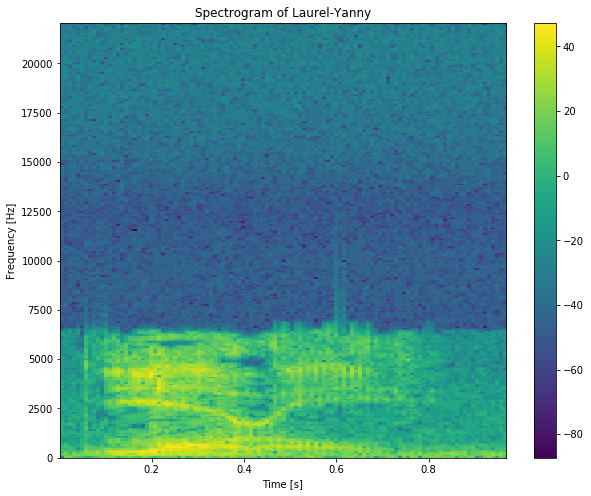

In [76]:
pyplot.figure(figsize=(10, 8))
pyplot.title("Spectrogram of %s" % "Laurel-Yanny")
pyplot.ylabel("Frequency [Hz]")
pyplot.xlabel("Time [s]")
spectrum, freqs, t, im = pyplot.specgram(pcm_values, NFFT=512, Fs=sampling_rate, mode="psd") # Compute the spectogram in 512-sample long blocks and power spectral density mode.
pyplot.colorbar(im)

## Part 2 FIR, IIR and Fourier filters
In this part we change the signal, by attenuation or amplification of specific frequencies, so that the sound recording sounds closer to "Laurel" or "Yanny".

### Identifying DFT indices corresponding to frequency ranges to zero out
* zeroing out all “high” frequencies, above a certain threshold
* zeroing out all “low” frequencies, bellow a certain threshold

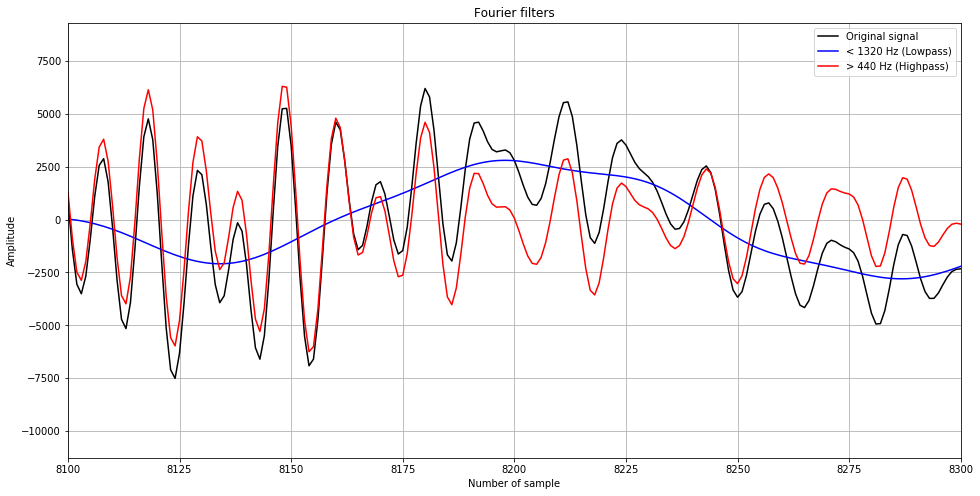

In [84]:
# Find DFT indices corresponding to frequency ranges to zero out
flt_lowpass = dft_frequencies < 1320
flt_highpass = dft_frequencies > 440

dft_y_copy = dft_y.copy()
dft_y_copy[flt_lowpass] = 0 # Keeping all frequencies higher than 1320 which can be then substracted from the original signal, resulting in a signal with freqs <1320.
attenuated_y = np.fft.irfft(dft_y_copy)
filtered_y1 = y - attenuated_y

dft_y_copy = dft_y.copy()
dft_y_copy[flt_highpass] = 0 # Keeping all frequencies lower than 440 which can be then substracted from the original signal, resulting in a signal with freqs >440.
attenuated_y = np.fft.irfft(dft_y_copy)
filtered_y2 = y - attenuated_y

# Plot short section of time series
pyplot.figure(figsize=(16, 8))
xlim = (8100, 8300)
section_range = np.arange(xlim[0], xlim[1] + 1)
pyplot.plot(section_range, pcm_values[section_range], "k")
pyplot.plot(section_range, filtered_y1[section_range], "b")
pyplot.plot(section_range, filtered_y2[section_range], "r")
pyplot.ylim([1.5 * pcm_values[section_range].min(), 1.5 * pcm_values[section_range].max()])
pyplot.xlim(xlim)
pyplot.legend(["Original signal", "< 1320 Hz (Low-pass)", "> 440 Hz (High-pass)"])
pyplot.title("Fourier filters")
pyplot.xlabel("Number of sample")
pyplot.ylabel("Amplitude")
pyplot.grid()

>As a side note, it is interesting to point out that zeroing bins in the frequency domain is the same as multiplying by a rectangular function in the frequency domain, which in turn means that we implicitly apply convolution with a Sinc window on the signal in the time domain. This may lead to the production of artifacts because the Sinc function contains large ripples (ringing).<br>
In this case, such phenomenon is not observed due to the nature of the signal.
<a href="https://dsp.stackexchange.com/questions/6220/why-is-it-a-bad-idea-to-filter-by-zeroing-out-fft-bins">Reference in Stack Exchange</a>

### Low-pass filtered

In [86]:
Audio(data=filtered_y1, rate=sampling_rate)

### High-pass filtered

In [87]:
Audio(data=filtered_y2, rate=sampling_rate)

### Use of 8th Order Butterworth filters (IIR)

420 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


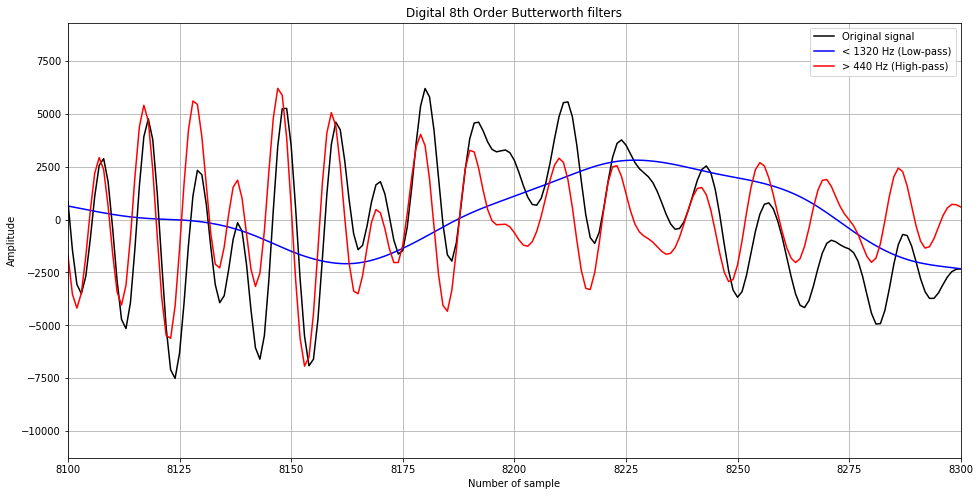

In [107]:
N = 8  # Filter Order
nyq = 0.5 * sampling_rate
lowcut = 1320
fc_low = lowcut / nyq  # normalized cut-off frequency
highcut = 440
fc_high = highcut / nyq  # normalized cut-off frequency

%timeit lowpass_b, lowpass_a = butter(N, fc_low, btype="lowpass")
highpass_b, highpass_a = butter(N, fc_high, btype="highpass")

filtered_y1b = lfilter(lowpass_b, lowpass_a, pcm_values)
filtered_y2b = lfilter(highpass_b, highpass_a, pcm_values)

# Plot short section of time series
pyplot.figure(figsize=(16, 8))
xlim = (8100, 8300)
section_range = np.arange(xlim[0], xlim[1] + 1)
pyplot.plot(section_range, pcm_values[section_range], "k")
pyplot.plot(section_range, filtered_y1b[section_range], "b")
pyplot.plot(section_range, filtered_y2b[section_range], "r")
pyplot.ylim([1.5 * pcm_values[section_range].min(), 1.5 * pcm_values[section_range].max()])
pyplot.xlim(xlim)
pyplot.legend(["Original signal", "< 1320 Hz (Low-pass)", "> 440 Hz (High-pass)"])
pyplot.title("Digital 8th Order Butterworth filters")
pyplot.xlabel("Number of sample")
pyplot.ylabel("Amplitude")
pyplot.grid()

>Note that we use the function *'scipy.signal.lfilter'* which filters the dataset once in forward direction which introduces phase shift (delay). Alternatively, we could use *'scipy.signal.filtfilt'* which applies the digital filter twice, once forward and once backwards, resulting in zero phase, but the filter order becomes twice that of the original.

### Low-pass Butterworth filtered

In [96]:
Audio(data=filtered_y1b, rate=sampling_rate)

### High-pass Butterworth filtered

In [97]:
Audio(data=filtered_y2b, rate=sampling_rate)

### Use of FIR filter

Finally, we decided to implement a FIR filter with similiar characteristics to the fourier filters.<br>
*Reference https://fiiir.com/*<br>
Design criteria:<br>
Cut-off frequency -> 1320 Hz<br>
Transition bandwidth (as narrow as possible) -> 441 Hz (which results in a filter of order 310, interesting to compare computation time)

3.33 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


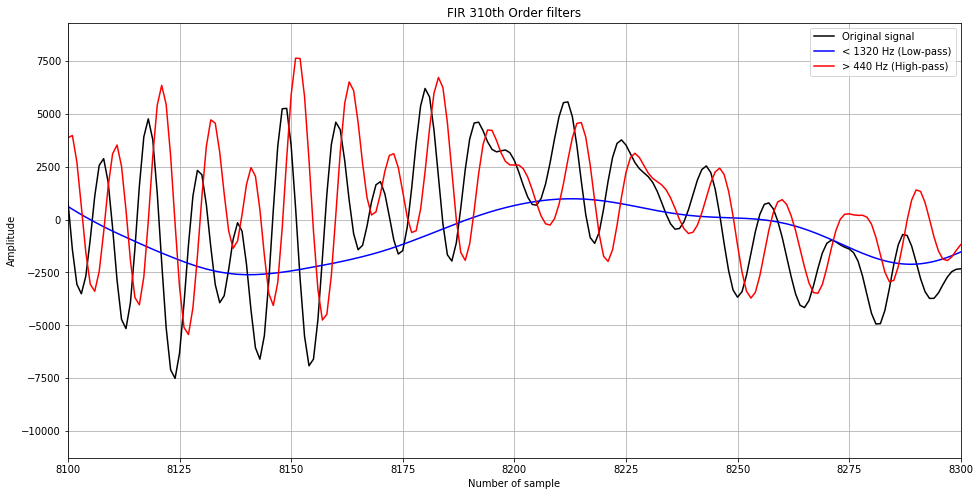

In [115]:
fc = 1320
filter_len = 311

h = np.sinc(2 * fc / sampling_rate * (np.arange(filter_len) - (filter_len - 1) / 2))  # Compute sinc filter.
h *= np.hamming(filter_len)  # Apply Hamming window.
h /= np.sum(h)  # Normalize to get unity gain.
%timeit filtered_signal_lowpass = np.convolve(pcm_values, h).astype(np.int16)

# Create a high-pass filter from the low-pass filter through spectral inversion.
h_highpass = -h
h_highpass[(N - 1) // 2] += 1
filtered_signal_highpass = np.convolve(pcm_values, h_highpass).astype(np.int16)


# Plot short section of time series
pyplot.figure(figsize=(16, 8))
xlim = (8100, 8300)
section_range = np.arange(xlim[0], xlim[1] + 1)
pyplot.plot(section_range, pcm_values[section_range], "k")
pyplot.plot(section_range, filtered_signal_lowpass[section_range], "b")
pyplot.plot(section_range, filtered_signal_highpass[section_range], "r")
pyplot.ylim([1.5 * pcm_values[section_range].min(), 1.5 * pcm_values[section_range].max()])
pyplot.xlim(xlim)
pyplot.legend(["Original signal", "< 1320 Hz (Low-pass)", "> 440 Hz (High-pass)"])
pyplot.title("FIR 310th Order filters")
pyplot.xlabel("Number of sample")
pyplot.ylabel("Amplitude")
pyplot.grid()

By using the magic funtion %timeit in jupyter we can see that the necessary computation time of the FIR filter (310th Order) is approximately 8 times bigger than the 8th Order Butterworth.

### Low-pass FIR filtered

In [113]:
Audio(data=filtered_signal_lowpass, rate=sampling_rate)

### High-pass FIR filtered

In [114]:
Audio(data=filtered_signal_highpass, rate=sampling_rate)